# 신경망 깊게 쌓아 컬러 데이터셋에 적용하기
Convolutional Neural Network (CNN) 을 쌓아올려 딥한 러닝을 해봅시다.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
DEVICE
#CUDA 설정 방법
# 상단 런타임 --> 런타임 유형 변경 --> 하드웨어 가속기 --> GPU 설정 --> 저장 !

device(type='cuda')

## 하이퍼파라미터 

In [ ]:
# Epochs과 batch size는 변경 X 
EPOCHS     = 100#1 
BATCH_SIZE = 32

## 데이터셋 불러오기

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./.data/cifar-10-python.tar.gz to ./.data


# 모델 초기화



In [ ]:
# 수정 X

def initialize_model(model_name, num_classes,use_pretrained=True):
    model_ft = None

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        # 제일 마지막 FC layer를 Cifar 클래스에 맞도록 Output 크기 교체 == 즉, resnet.fc를 새로운 nn.Linear를 정의하여 할당.
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name =='resnet101':
        model_ft = models.resnet101(use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'resnet152':
        model_ft = models.resnet152(use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        # 제일 마지막 FC layer를 Cifar 클래스에 맞도록 Output 크기 교체 == 즉, resnet.fc를 새로운 nn.Linear를 정의하여 할당.
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    elif model_name == "base":
      model_ft = BaseModel(num_classes)
      
    return model_ft


### 나만의 CNN 모델을 만들어 CIFAR10 이미지 분류 성능 측정
#### 제공된 코드에서 BaseModel (CNN모델) 정확도 성능 올리기


(1) nn.Conv2d 함수 중 Filter의 개수, 사이즈를 조절하는 값을 찾아 변동 시킨 경우

(2) nn.Conv2d 네트워크를 추가 적용해보는 경우

(3) 기타 등등.. 다양한 방법 시도

 * BaseModel class 속 코드 변경 후 아래의 "코드 돌려보기" 부분 실행 *

In [ ]:
# 과제 1번
class BaseModel(nn.Module):
  def __init__(self,num_classes):
    super(BaseModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 5) # 합성곱 연산 (입력 채널 수: 3(RGB), 출력 채널 수: 32, 필터 크기: 5x5, stride=1(default))
    self.conv2 = nn.Conv2d(32, 64, 5) # 합성곱 연산 (입력 채널 수: 32, 출력 채널수: 64, 필터 크기: 5x5, stride=1(default))
    self.conv3 = nn.Conv2d(64, 256, 5)  # 합성곱 연산 (입력 채널 수: 64, 출력 채널수: 256, 필터 크기: 5x5, stride=1(default))
    

    self.pool = nn.MaxPool2d(2,2,1) # 풀링 계층 (필터크기 2x2, stride=2, padding=1)
    
    self.fc1 = nn.Linear(256 * 2 * 2, 256) # 2x2 피쳐맵 256개를 일렬로 피면 256x2x2개의 노드가 생성됨.
    self.fc2 = nn.Linear(256, 120)
    self.fc3 = nn.Linear(120, 84)
    self.fc4 = nn.Linear(84, num_classes)
    self.dropout = nn.Dropout(p=0.25, inplace=False)
    
  def forward(self, x):
    x = F.relu(self.conv1(x)) # conv1 -> ReLU -> pool1
    x = self.pool(x)

    x = F.relu(self.conv2(x)) # conv1 -> ReLU  -> pool1
    x = self.pool(x)

    x = F.relu(self.conv3(x)) # conv1 -> ReLU -> dropout -> pool1
    x = self.dropout(x)
    x = self.pool(x)

    x = x.view(-1, 256 * 2 * 2) # 2x2 피쳐맵 256개를 일렬로 만든다.
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [ ]:
# 아래 코드 작성하세요
num_classes = 10   # FC layer Output --> Cifar Dataset 클래스에 맞도록 변경하세요


#ResNet_18 vs VGG_11 
### 1. ImageNet 데이터셋으로 선행 학습된 Resnet or Vgg 모델을 Cifar-10 데이터셋에 대한 전이학습을 진행해주세요

- 주의
 - resnet101, 152은 layer 깊이가 깊음 --> 학습 시간이 오래 걸림
 - 적절한 하이퍼파라미터 설정 후 실행

## 준비

In [ ]:
#아래 4가지 모델 중 하나만 주석 해제 후 사용
# Resnet-18  Load
# model = initialize_model('resnet18',num_classes,True)
# Resnet-101  Load
# model = initialize_model('resnet101',num_classes,True)
# Resnet-152  Load
# model = initialize_model('resnet152',num_classes,True)
# VGG-11 Load
# model = initialize_model('vgg',num_classes,True)
# BaseModel
model = initialize_model('base',num_classes,True)

print(model)
#Learning rate 변경시 아래 lr 의 값 변경
# optimizer 함수 변경은 자유!!
optimizer = optim.SGD(model.parameters(), lr = 0.1)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# 학습 시간이 오래 걸릴 경우에는 step_size = 5 로 변경


BaseModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## 학습하기

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    model = model.to(DEVICE)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

## 테스트하기

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 코드 돌려보기

자, 이제 모든 준비가 끝났습니다. 코드를 돌려서 실제로 훈련이 되는지 확인해봅시다!

In [ ]:
model = model.to(DEVICE)
for epoch in range(1, EPOCHS + 1):
    scheduler.step()
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1] Test Loss: 1.6537, Accuracy: 36.42%
[2] Test Loss: 1.4585, Accuracy: 48.12%
[3] Test Loss: 1.1264, Accuracy: 60.74%
[4] Test Loss: 1.1080, Accuracy: 60.43%
[5] Test Loss: 0.8669, Accuracy: 69.88%
[6] Test Loss: 0.8360, Accuracy: 71.19%
[7] Test Loss: 0.8238, Accuracy: 71.93%
[8] Test Loss: 0.8114, Accuracy: 72.41%
[9] Test Loss: 0.7864, Accuracy: 72.92%
[10] Test Loss: 0.7669, Accuracy: 73.88%
[11] Test Loss: 0.7634, Accuracy: 74.20%
[12] Test Loss: 0.7603, Accuracy: 74.28%
[13] Test Loss: 0.7610, Accuracy: 74.22%
[14] Test Loss: 0.7564, Accuracy: 74.24%
[15] Test Loss: 0.7555, Accuracy: 74.29%
[16] Test Loss: 0.7550, Accuracy: 74.33%
[17] Test Loss: 0.7545, Accuracy: 74.39%
[18] Test Loss: 0.7547, Accuracy: 74.39%
[19] Test Loss: 0.7545, Accuracy: 74.45%
[20] Test Loss: 0.7545, Accuracy: 74.41%
[21] Test Loss: 0.7545, Accuracy: 74.42%
[22] Test Loss: 0.7544, Accuracy: 74.40%
[23] Test Loss: 0.7544, Accuracy: 74.41%
[24] Test Loss: 0.7543, Accuracy: 74.44%
[25] Test Loss: 0.7543, A

KeyboardInterrupt: ignored

# 사전 학습이 완료된 ResNet-18 모델의 Conv Layer 시각화

### Conv Layer 깊이에 따른 특징 맵을 분석해주세요!
  -> ex ) Conv 0 Layer에서는 이미지의 윤곽선에 대한 특징을 추출했다면, Conv 4 Layer에서는 이미지의 색에 대한 특징을 추출하였습니다.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import cv2
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1 , 2 , 0) # transposing the image matrix
    image = image * np.array((0.5 , 0.5 , 0.5)) + np.array((0.5 , 0.5 , 0.5)) # applying transform to the trnsor
    image = image.clip(0,1)
    return image

class Conv_layervis(nn.Module):
    def __init__(self,layer,img,layer_num):
        super(Conv_layervis , self).__init__()
         
        self.layer = layer
        self.img = img
        self.weights = self.layer.weight.data # Load the weights
        self.layer_num = layer_num
        self.w = self.weights.cpu().numpy()
        
        self.fig = plt.figure(figsize = (30 , 10))

        self.columns = 5*2
        self.rows = 2

        for i in range(self.columns * self.rows):
            self.fig.add_subplot(self.rows , self.columns , i+1)
            if(i%2 == 0):
                plt.title('Conv {} Filter'.format(self.layer_num))
                plt.imshow(self.w[int(i/2)][0] , cmap = 'gray')
            else:
                self.c = cv2.filter2D(self.img , -1 , self.w[int((i-1)/2)][0])
                plt.title('Conv {} Image'.format(self.layer_num))
                plt.imshow(self.c , cmap = 'gray')


 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

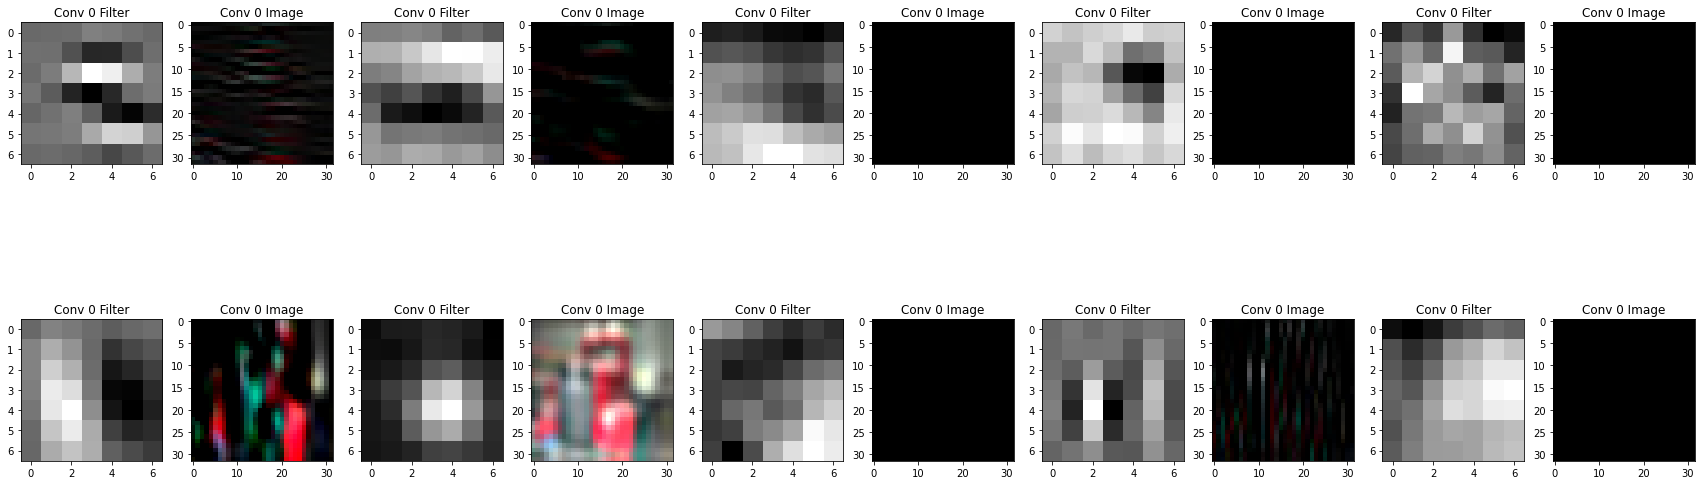

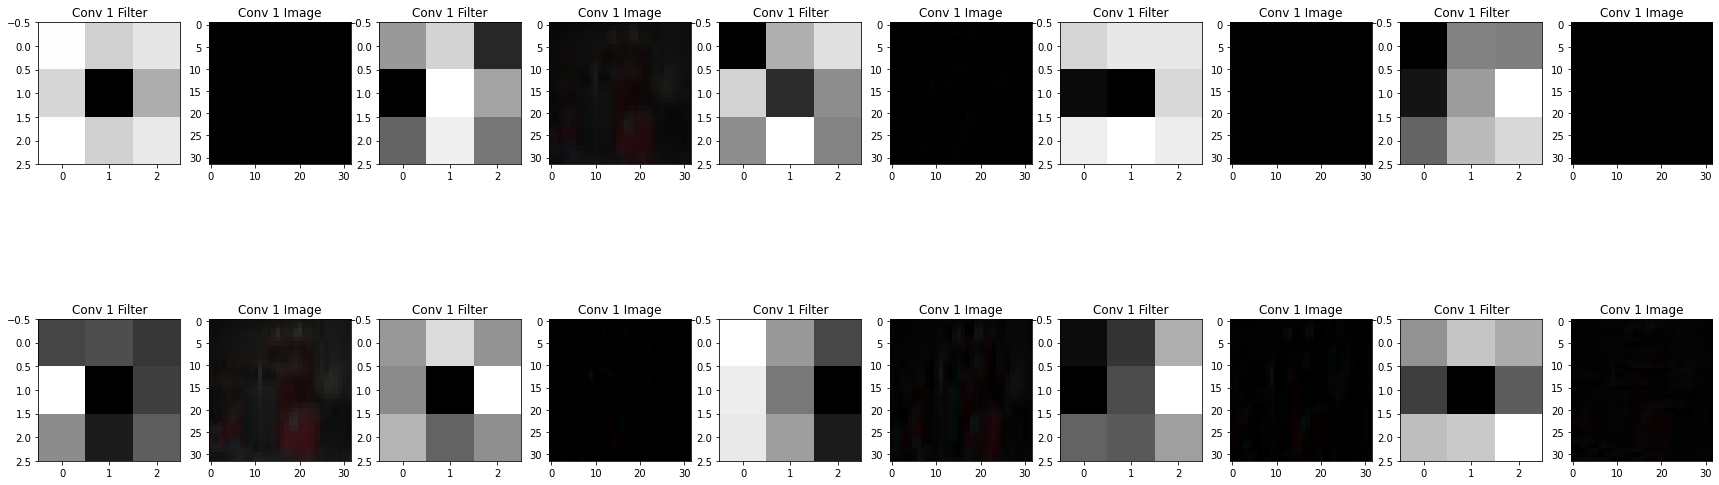

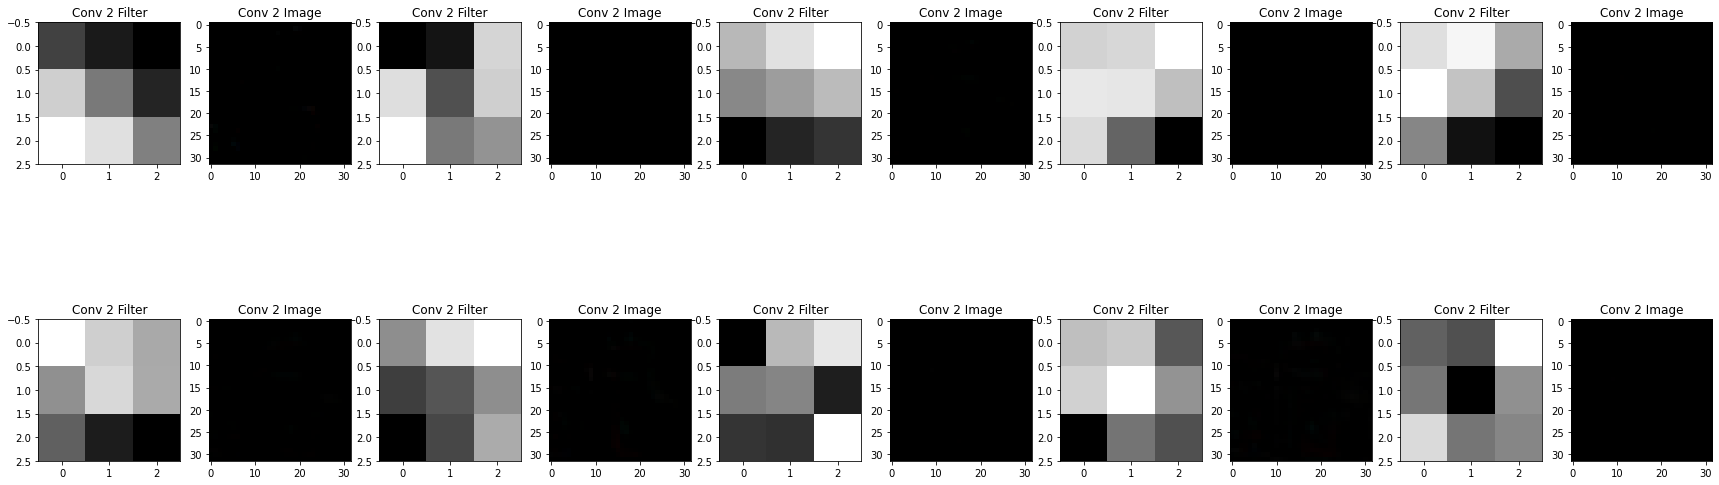

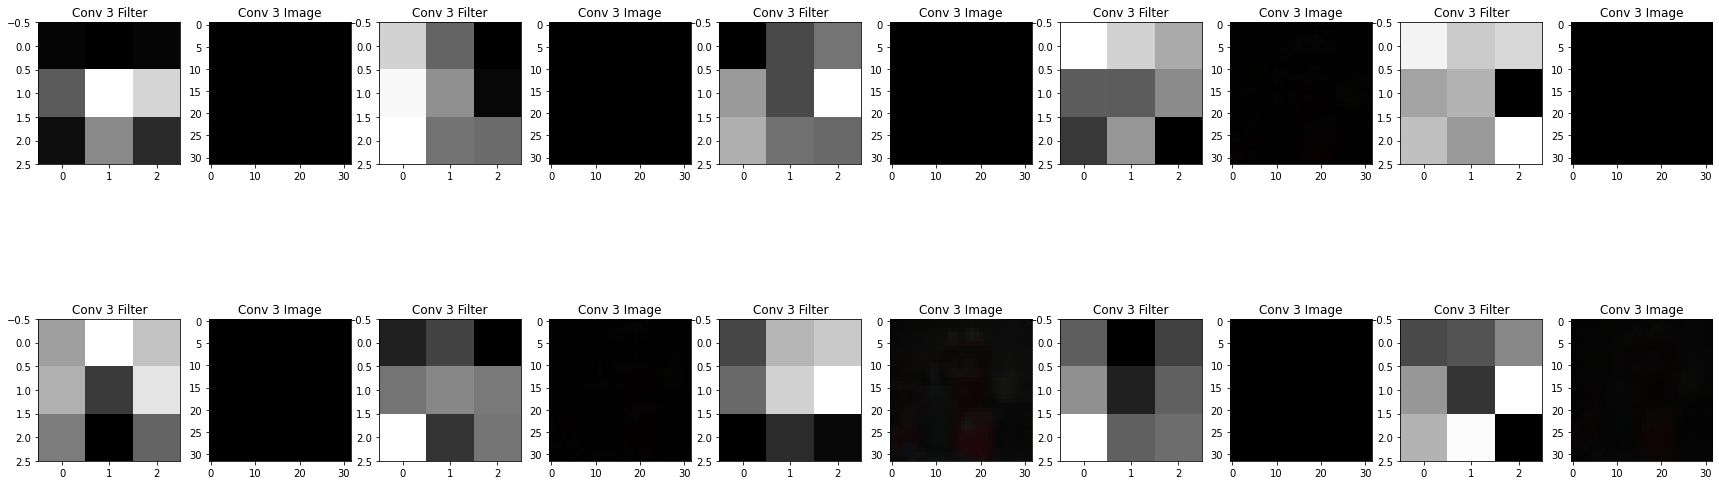

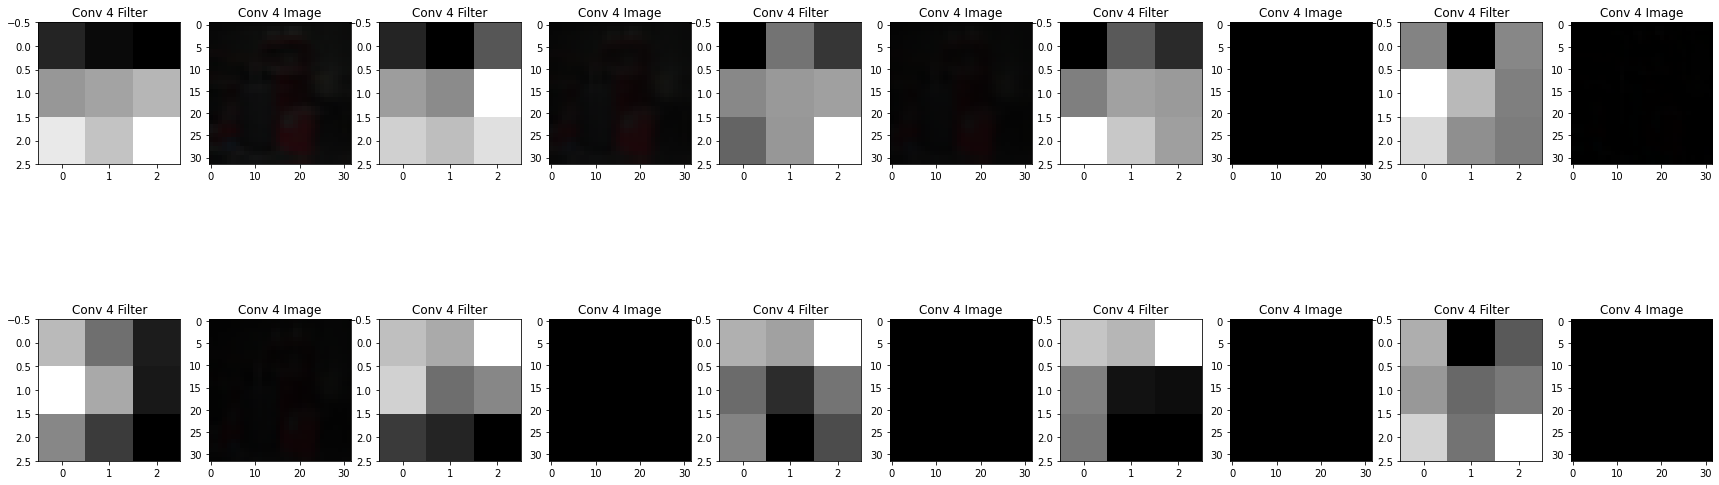

In [ ]:
# ResNet 모델 Conv Filter 시각화

images , labels = next(iter(test_loader))

model = initialize_model("resnet18",num_classes,True)

model_conv_layer = {'resnet' :[model.conv1,model.layer1[0].conv1,model.layer2[0].conv1,model.layer3[0].conv1,model.layer4[0].conv1]}
model_name = 'resnet'

for layer_num,conv_layer in enumerate(model_conv_layer[model_name]):
  Conv_layervis(conv_layer , im_convert(images[0]),layer_num)